<a href="https://colab.research.google.com/github/AxelRK200/trend_finder_dataiku/blob/main/Exploration/Weekly_MA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install yfinance
!pip install plotly
!pip install ta

In [110]:
import pandas as pd, numpy as np
from ta.trend import SMAIndicator
import yfinance as yf
import datetime
import seaborn as sns

# Input #

### Import ###

In [85]:
ndx = yf.Ticker("^NDX")
hist = ndx.history(period="max", interval="1wk")

In [86]:
# Passe la date d'index à colonne
hist.reset_index(inplace=True)

In [87]:
hist.drop(columns=['High','Low','Dividends','Stock Splits'], inplace=True)

In [88]:
hist.tail()

,Date,Open,Close,Volume
1941,2022-12-12 00:00:00-05:00,11572.259766,11243.719727,29946270000
1942,2022-12-19 00:00:00-05:00,11243.000000,10985.450195,22410180000
1943,2022-12-26 00:00:00-05:00,10944.299805,10939.759766,15783390000
1944,2023-01-02 00:00:00-05:00,11038.419922,11040.349609,19830080000
1945,2023-01-09 00:00:00-05:00,11133.070312,11459.613281,21846465000


### Mise en forme date ###

In [89]:
hist["Num_Semaine"] = hist.Date.apply(lambda d : d.strftime('%Y-%V'))
hist["Date"] = hist.Date.apply(lambda d : d.strftime('%Y-%m-%d'))

In [90]:
hist["Open"] = hist.Open.apply(lambda f : round(f,2))
hist["Close"] = hist.Close.apply(lambda f : round(f,2))

In [91]:
hist.tail()

,Date,Open,Close,Volume,Num_Semaine
1941,2022-12-12,11572.26,11243.72,29946270000,2022-50
1942,2022-12-19,11243.00,10985.45,22410180000,2022-51
1943,2022-12-26,10944.30,10939.76,15783390000,2022-52
1944,2023-01-02,11038.42,11040.35,19830080000,2023-01
1945,2023-01-09,11133.07,11459.61,21846465000,2023-02


# Indicateur technique #

In [92]:
hist.isnull().sum()

Date           0
Open           0
Close          0
Volume         0
Num_Semaine    0
dtype: int64

In [93]:
s_sma = SMAIndicator(close = hist.Close, window=40).sma_indicator()

In [94]:
hist["SMA_40"] = s_sma

In [95]:
hist.dropna(subset=['SMA_40'], inplace=True)

In [96]:
hist["SMA_40"] = hist.SMA_40.apply(lambda f : round(f,2))

In [97]:
hist.reset_index(drop=True, inplace=True)

In [98]:
hist.head()

,Date,Open,Close,Volume,Num_Semaine,SMA_40
0,1986-06-30,161.62,164.51,988800000,1986-27,139.96
1,1986-07-07,164.51,152.85,1162800000,1986-28,141.02
2,1986-07-14,152.85,147.76,1160400000,1986-29,141.94
3,1986-07-21,147.76,148.26,975500000,1986-30,142.79
4,1986-07-28,148.26,144.19,975920000,1986-31,143.55


# Feature Engineering #

In [107]:
def refined_indicators(df):
  '''Determines whether closing price is over (1) or below (0) sma'''

  indicator = 0

  df_calc = df[["Close","SMA_40"]].copy()
  df_calc["diff"] = df_calc.Close - df_calc.SMA_40
  df_calc["relative_distance"] = ((df_calc.Close - df_calc.SMA_40)/df_calc.SMA_40)*100

  df_calc["diff"] = df_calc["diff"].apply(lambda x: 1 if x>0 else 0)
  df_calc["relative_distance"] = df_calc["relative_distance"].apply(lambda x: round(x,2))
  
  return df_calc["diff"], df_calc["relative_distance"] 

In [108]:
hist["Position"], hist["Relative_distance"] = refined_indicators(hist)

In [109]:
hist.head(10)

,Date,Open,Close,Volume,Num_Semaine,SMA_40,Position,Relative_distance
0,1986-06-30,161.62,164.51,988800000,1986-27,139.96,1,17.54
1,1986-07-07,164.51,152.85,1162800000,1986-28,141.02,1,8.39
2,1986-07-14,152.85,147.76,1160400000,1986-29,141.94,1,4.10
3,1986-07-21,147.76,148.26,975500000,1986-30,142.79,1,3.83
4,1986-07-28,148.26,144.19,975920000,1986-31,143.55,1,0.45
5,1986-08-04,144.19,142.29,957520000,1986-32,144.20,0,-1.32
6,1986-08-11,142.29,149.57,1071240000,1986-33,144.96,1,3.18
7,1986-08-18,149.57,150.95,1047800000,1986-34,145.68,1,3.62
8,1986-08-25,150.95,151.70,927780000,1986-35,146.37,1,3.64
9,1986-09-01,151.70,149.67,816960000,1986-36,146.96,1,1.84


# EDA

In [114]:
sns.set(rc={"figure.figsize":(10, 8)})

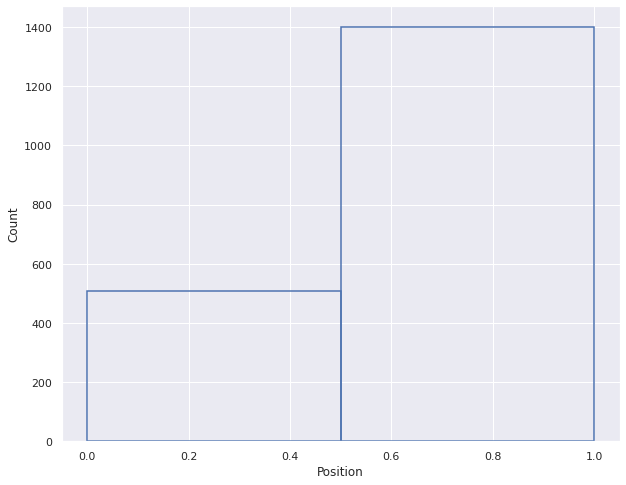

In [115]:
sns.histplot(data=hist, x="Position", fill=False, bins=2)

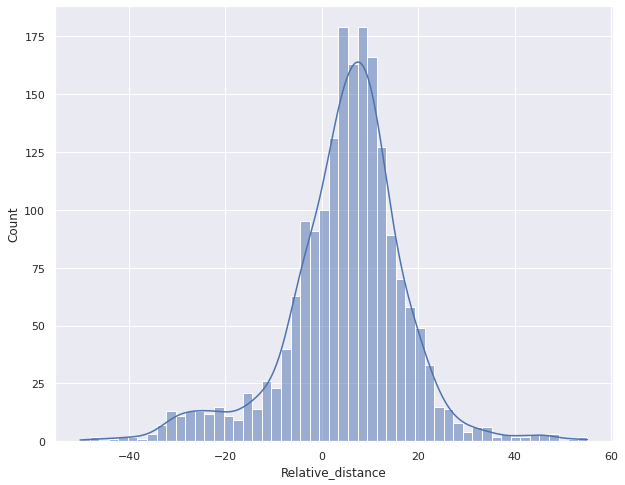

In [116]:
sns.histplot(data=hist, x="Relative_distance", kde=True)

# Study with ln returns & distance

In [117]:
hist["Last_wk_close"] = hist.Close.shift(1)

In [120]:
hist.dropna(subset=['Last_wk_close'], inplace=True)
hist.reset_index(drop=True, inplace=True)

In [118]:
from numpy import log as ln

In [126]:
def ln_indicators(df):
  '''Calulates return and relative distance with natural log instead of % variation'''

  df_calc = df[["Close","SMA_40","Last_wk_close"]].copy()
  
  df_calc["ln_diff"] = ln(df.Close/df.Last_wk_close)
  df_calc["ln_diff"] = df_calc["ln_diff"].apply(lambda x: round(x,2))

  df_calc["ln_relative_distance"] = ln(df.Close/df.SMA_40)*100
  df_calc["ln_relative_distance"] = df_calc["ln_relative_distance"].apply(lambda x: round(x,2))

  
  return df_calc["ln_diff"], df_calc["ln_relative_distance"] 

In [127]:
hist["ln_Return"], hist["ln_Relative_distance"] = ln_indicators(hist)

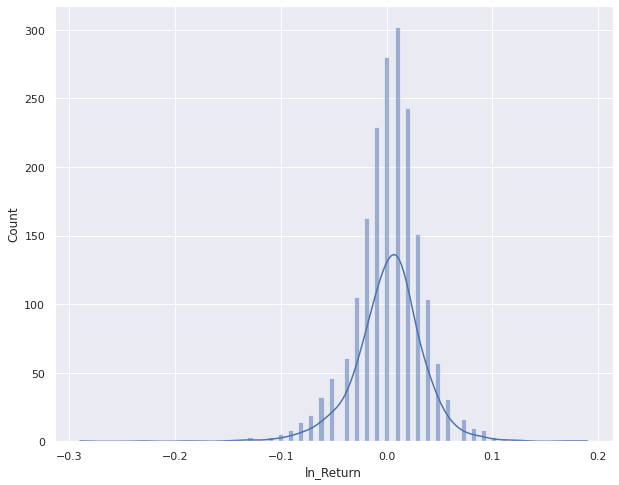

In [128]:
sns.histplot(data=hist, x="ln_Return", kde=True)

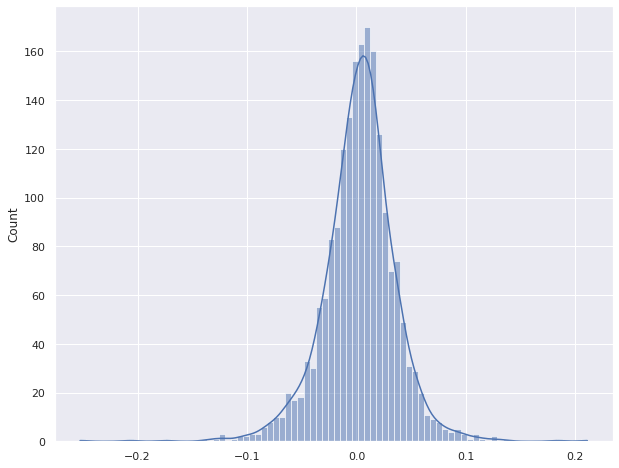

In [135]:
sns.histplot(data=hist, x=(hist.Close-hist.Last_wk_close)/hist.Last_wk_close, kde=True)

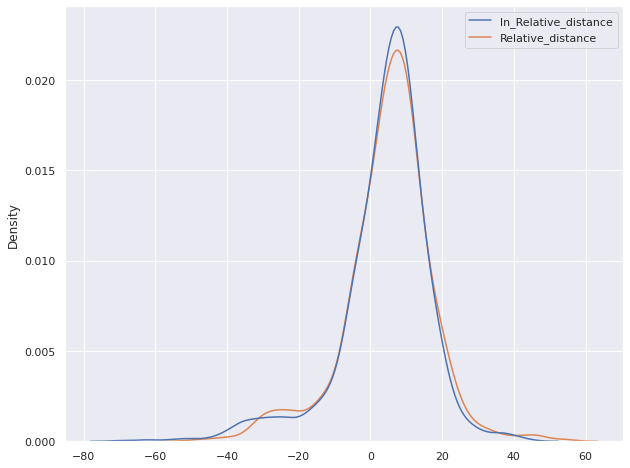

In [137]:
sns.kdeplot(data=hist[["ln_Relative_distance","Relative_distance"]])

In [138]:
hist["Perf_pct"] = (hist.Close-hist.Last_wk_close)/hist.Last_wk_close

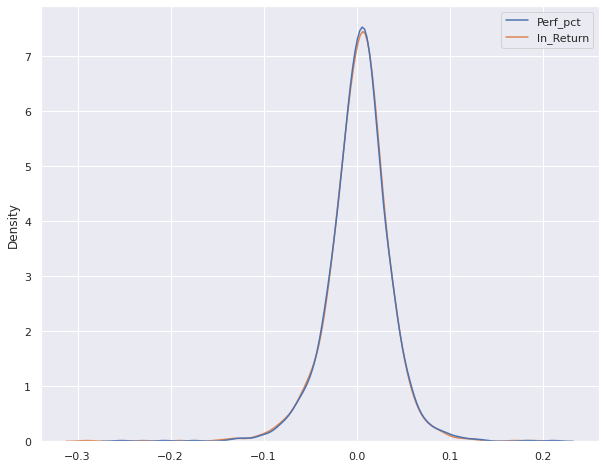

In [139]:
sns.kdeplot(data=hist[["Perf_pct","ln_Return"]])